In [71]:
#Load Libraries
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tkinter as tk
import re
from tkinter import filedialog
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import RegscorePy as rp

In [72]:
# Load the OpenCV face cascade
face_cascade = cv2.CascadeClassifier('/Users/mac/Desktop/software_projects/flask/inward_backend/inward_backend/haarcascade_frontalface_default.xml')
kernel = np.ones((5,5),np.float32)/25
def preprocess_img(img, img_size):
    #Face Detection & Cropping
    faces = face_cascade.detectMultiScale(img, 1.1, 4)
    # Grayscale conversion
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Histogram equalization
    img = cv2.equalizeHist(img)
    for (x, y, w, h) in faces: 
        img_ = img[y:y+h, x:x+w]
    try:
        #Resizing/Normalizing
        img_ = cv2.resize(img_,(img_size, img_size))
        #Mean Filtering
        img_ = cv2.filter2D(img_,-1,kernel)
    except Exception as e:
        #print("Exception: "+str(e))
        return img
    return img_

In [73]:
def preprocess(class_path, img_size):
    for filename in os.listdir(class_path):
        #img = cv2.imread(os.path.join(class_path,filename), cv2.IMREAD_GRAYSCALE)
        img = cv2.imread(os.path.join(class_path,filename))
        img = preprocess_img(img, img_size)
        cv2.imwrite(os.path.join("Processed "+class_path,filename), img)

In [74]:
preprocess("/Users/mac/Downloads/Binary Classified Pain Images", 224)

In [75]:
for filename in os.listdir("/Users/mac/Downloads/Binary Classified Pain Images"):
    #Conversion to grayscale
    img = cv2.imread(os.path.join("/Users/mac/Downloads/Binary Classified Pain Images",filename), cv2.IMREAD_GRAYSCALE)
    tran = transforms.ToTensor()
    img = tran(img)
    break

In [76]:
data_transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),
     transforms.Grayscale(num_output_channels=1)])
trainset = datasets.ImageFolder(root="/Users/mac/Downloads/UNBC_Croped_labeld", transform=data_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 10, shuffle = True)

In [77]:
testset = datasets.ImageFolder(root="/Users/mac/Downloads/UNBC_Croped_labeld_test", transform=data_transform)
testloader = torch.utils.data.DataLoader(testset)

In [78]:
num_epochs = 20
batch_size = 10
learning_rate = 0.0001
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.layer1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer5 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 512, 1000)
        self.fc2 = nn.Linear(1000, 2)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [79]:
model = NN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [80]:
total_step = len(trainloader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),(correct / total) * 100))
        loss_list.append(loss.item())
        acc_list.append(correct / total)

Epoch [1/20], Step [1/120], Loss: 0.6871, Accuracy: 70.00%
Epoch [1/20], Step [2/120], Loss: 0.6947, Accuracy: 50.00%
Epoch [1/20], Step [3/120], Loss: 0.6827, Accuracy: 60.00%
Epoch [1/20], Step [4/120], Loss: 0.6626, Accuracy: 70.00%
Epoch [1/20], Step [5/120], Loss: 0.7283, Accuracy: 40.00%
Epoch [1/20], Step [6/120], Loss: 0.6251, Accuracy: 80.00%
Epoch [1/20], Step [7/120], Loss: 0.7050, Accuracy: 50.00%
Epoch [1/20], Step [8/120], Loss: 0.6753, Accuracy: 60.00%
Epoch [1/20], Step [9/120], Loss: 0.6726, Accuracy: 60.00%
Epoch [1/20], Step [10/120], Loss: 0.7522, Accuracy: 40.00%
Epoch [1/20], Step [11/120], Loss: 0.6735, Accuracy: 60.00%
Epoch [1/20], Step [12/120], Loss: 0.7747, Accuracy: 30.00%
Epoch [1/20], Step [13/120], Loss: 0.6765, Accuracy: 60.00%
Epoch [1/20], Step [14/120], Loss: 0.7004, Accuracy: 50.00%
Epoch [1/20], Step [15/120], Loss: 0.6171, Accuracy: 90.00%
Epoch [1/20], Step [16/120], Loss: 0.6971, Accuracy: 50.00%
Epoch [1/20], Step [17/120], Loss: 0.6972, Accura

In [89]:
pd.DataFrame(acc_list).to_excel('accuracies.xlsx')
pd.DataFrame(loss_list).to_excel('losses.xlsx')

In [90]:
torch.save(model.state_dict(), "./pain_detection_nn.pth")

In [91]:
#load Model
model = NN()
model.load_state_dict(torch.load("pain_detection_nn.pth"))

<All keys matched successfully>

In [92]:
model.eval()
actual_outputs=[]
predicted_outputs=[]
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        actual_outputs.append(labels.item())
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_outputs.append(predicted.item())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = (correct / total) * 100
print('The test accuracy is: {} %'.format(accuracy))

The test accuracy is: 95.47123623011015 %


<Axes: >

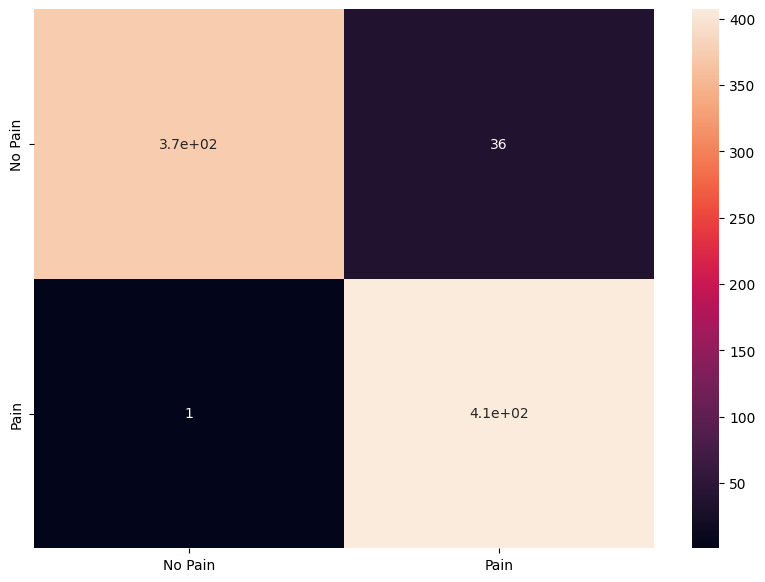

In [93]:
cm = confusion_matrix(actual_outputs, predicted_outputs)
df_cm = pd.DataFrame(cm, index = ["No Pain", "Pain"],
                  columns = ["No Pain", "Pain"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

2024-06-12 14:36:59.685 Python[47869:2369377] +[CATransaction synchronize] called within transaction
2024-06-12 14:36:59.824 Python[47869:2369377] +[CATransaction synchronize] called within transaction
2024-06-12 14:36:59.909 Python[47869:2369377] +[CATransaction synchronize] called within transaction
2024-06-12 14:37:02.020 Python[47869:2369377] +[CATransaction synchronize] called within transaction


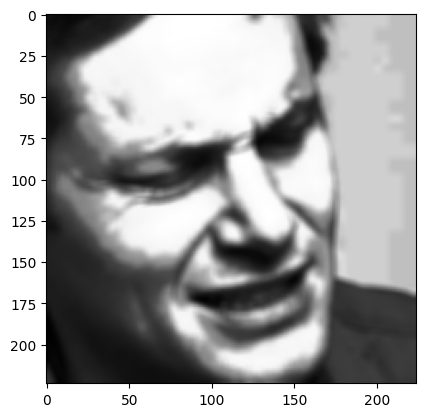

In [122]:
#Open Image
root = tk.Tk()
root.withdraw()
path = filedialog.askopenfilename()
new_img = cv2.imread(path)
processed_img = preprocess_img(new_img, 224)
plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))

In [123]:
#Preprocess Image
tran = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])
processed_img = tran(processed_img)

In [124]:
#Assess Pain
output = model(processed_img[None,...])

In [125]:
value, index = torch.max(output, 1)
if index==0:
    print("No Pain")
else:
    print("Pain")

Pain
